In [1]:
import networkx as nx

In [2]:
import os, sys
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:   
    sys.exit("please declare environment variable 'SUMO_HOME'")
    
import sumolib

In [3]:
net = sumolib.net.readNet('random.net.xml')

In [36]:
len(net.getNodes())

200

In [21]:
net.getEdges()[0].getLanes()[0].getLength()

127.46

#### Generating A Set of Sensors

Randomly pick k edges to place sensors.

Notes:

- We can simulate this either with induction loop (immediately below) or edge data (further down)
- Induction loop: sensors placed on lanes, can track speed
- Edge data: can track counts, apparently not speed
- Edge data easier if sensors are at arbitrary locations b/c we don't assume sensors are placed at all sinks

#### Generating Sensor Readings

Randomly choose traffic flows and speeds for our sensors.

EdgeID,SensorID

In [28]:
import numpy as np
import pandas as pd

# Generate uniform random estimates for both flows and speed
# Will need to revise this to generate realistic values
readings = pd.DataFrame(
    {
        "Detector": ["det{}".format(i) for i in range(len(sensors))],
        "Time": 0,
        "qPKW": np.random.randint(0, 1000, len(sensors)),
        "vPKW": np.random.uniform(0, 90, len(sensors))
    }
)

readings.head()

,Detector,Time,qPKW,vPKW
0,det0,0,247,11.814367
1,det1,0,897,81.555295
2,det2,0,102,16.028668
3,det3,0,864,73.140720
4,det4,0,418,37.747952


In [31]:
readings.to_csv("readings.csv", sep=";", index=False)

In [38]:
# Generate edge data
import xml.etree.cElementTree as ET

data = ET.Element("data")
for i in range(2):
    interval = ET.SubElement(data, "interval", id="int{}".format(i), begin=str(300 * i), end=str(300 * (i + 1)))
    for s in sensors:
        ET.SubElement(interval, "edge", id=s.getID(), entered=str(random.randint(0, 100)))
            
tree = ET.ElementTree(data)
tree.write("edgedata.xml")

In [1]:
# Read results

dump = sumolib.output.dump.readDump("dump.xml", "id")
# help(type(sumolib.output.dump.DumpReader(["id"])))
dump.getNodes()

NameError: name 'sumolib' is not defined

In [5]:
for route in sumolib.output.parse_fast('random.rou.xml', 'route', ['edges']):
    route_edges = route.edges.split()
    print(route_edges)
    
   # get node ids instead of edge ids
    route_nodes = [net.getEdge(edge).getFromNode().getID() for edge in route_edges]

['17', '-17', '-9', '7', '333', '-138', '-25', '25', '210', '585', '-613', '618', '867', '1919', '-2149', '-614', '-579', '577', '-577', '-383', '381', '-210', '138', '-333', '-7', '9', '19', '-19']


In [6]:
G = nx.fast_gnp_random_graph(20, 0.2, seed=None, directed=False)

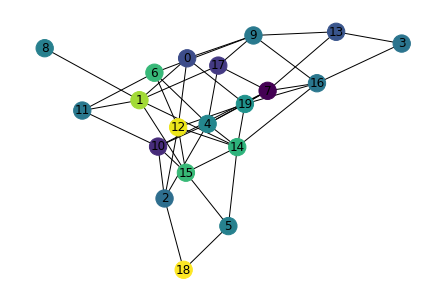

In [7]:
import numpy as np
import matplotlib.pyplot as plt

vals = np.random.rand(20)
nx.draw(G, node_color=vals, with_labels=True)
plt.show()

In [8]:
def smoothness(G, vals):
    return vals.transpose() @ nx.laplacian_matrix(G) @ vals

smoothness(G, vals)

4.310078561004897

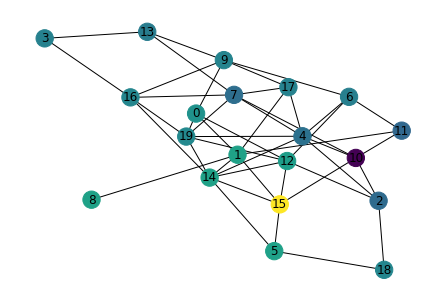

In [17]:
def degree_matrix(G):
    D = np.zeros((G.number_of_nodes(), G.number_of_nodes()))
    for i in range(G.number_of_nodes()):
        D[i][i] = G.degree[i]
    return D

def reset_labeled(x_hat, vals, labeled):
    for i in labeled:
        x_hat[i] = vals[i]

def label_prop_iterative(G, vals, labeled, iters):
    D = degree_matrix(G)
    P = np.linalg.inv(D) @ nx.adjacency_matrix(G)
    
    # Initialize
    x_hat = np.zeros(G.number_of_nodes())
    reset_labeled(x_hat, vals, labeled)
    
    for i in range(iters):
        x_hat = P @ x_hat
        reset_labeled(x_hat, vals, labeled)
        
    return x_hat

preds = label_prop_iterative(G, vals, {5, 10, 15}, 10000)
nx.draw(G, node_color=preds, with_labels=True)
plt.show()